# `hw4`: Heart failure prediction

In [2]:
# Fill in this cell with your personal details:
# - Name: GUENFOUDI Ihabe
# - Student ID: s194071
# - Email: ihabe.guenfoudi@student.uliege.be

Deadline: **Friday, December 20, 23:59**.

Instructions:
- Submit your completed notebook on your personal Github repository created when accepting the assignment.
- All cells must be executable and their outputs should not be erased before submission.
- This case study must be carried out alone. You are not allowed to discuss or collaborate with other students.
- In January, you will have to explain and defend your solution during a 30-minute oral exam.
- The take-home exam (including its defense in January) will account for 50% of the final grade.

Comments:
- Solve the case study below by following the Bayesian workflow as best as possible.
- Follow the data visualization principles to make your plots effective and readable.
- Make the best use of the Python scientific ecosystem.
- Feel free to add comments when necessary.

# Introduction

Cardiovascular diseases are the number 1 cause of death globally, taking an estimated 17 million lives each year. In this case study, you will explore a dataset of health records of 299 patients who had heart failure, collected by [Chicco and Jurman](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5) (2020). Each patient profile includes 13 features based on their clinical and physical conditions. Your task is to analyze this dataset to understand which features correlate most strongly with heart failure.


# Data exploration

<div class="alert alert-success">
    
**Q1**. Load the `heart.csv` dataset into a data frame.
    
</div>

In [3]:
import os
import emcee
import corner
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, gamma
from scipy.optimize import minimize


In [4]:
import pandas as pd 

df = pd.read_csv("heart.csv")
print(df.head())
print("Data types informations \n")
print(df.info()) 
print("data types \n")
print(df.dtypes)


    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2       

<div class="alert alert-success">
    
**Q2**. Explore the dataset and report relevant insights. 

</div>

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB
No

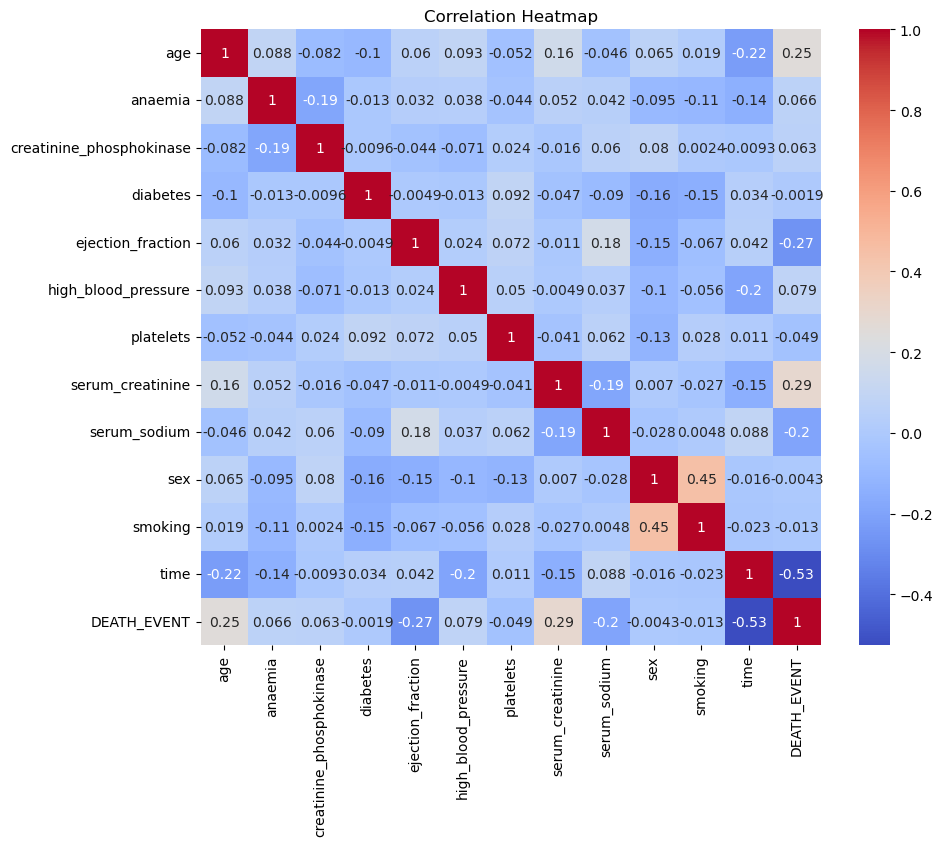

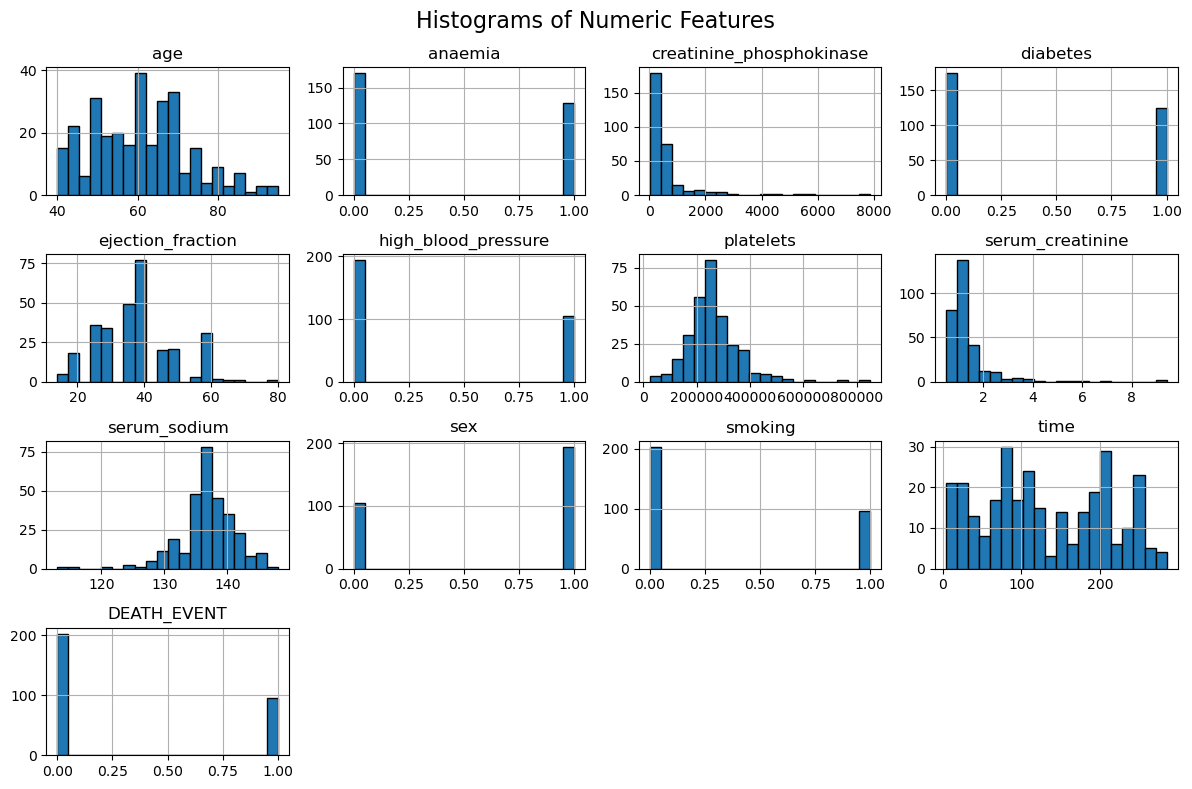

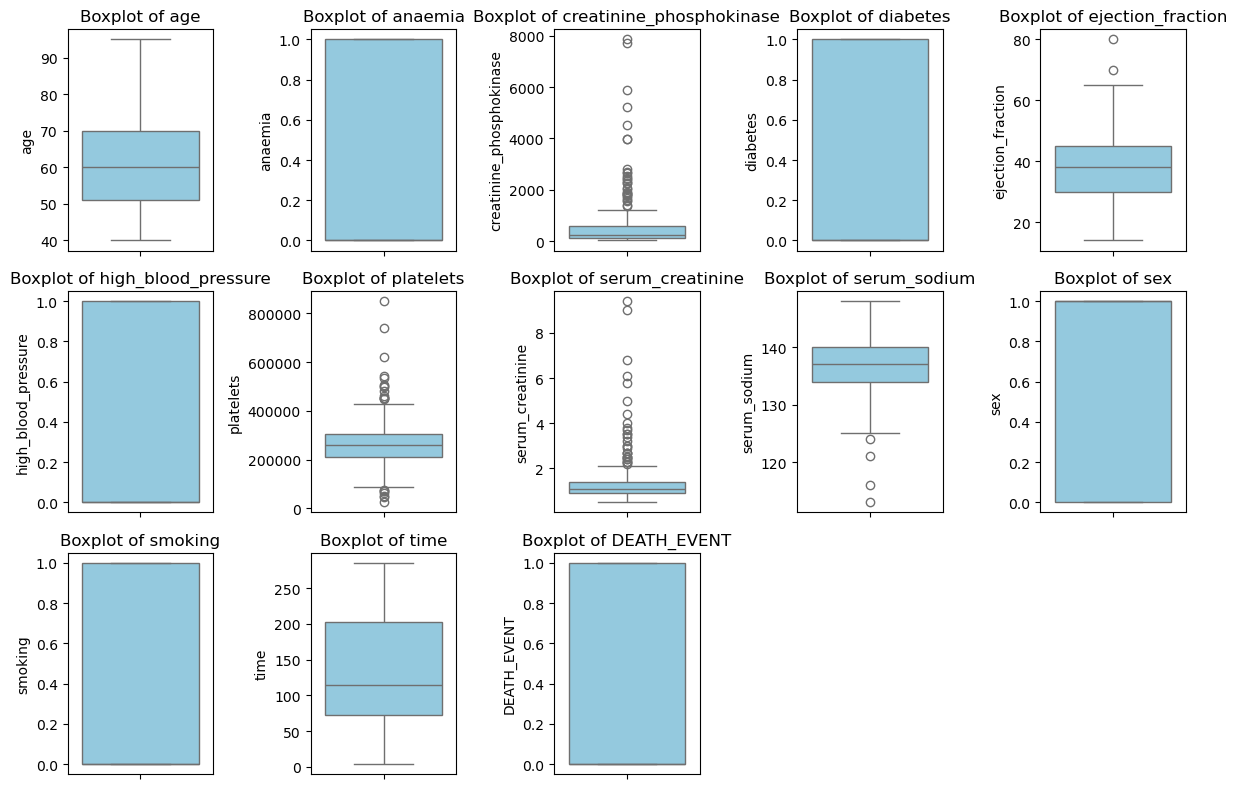

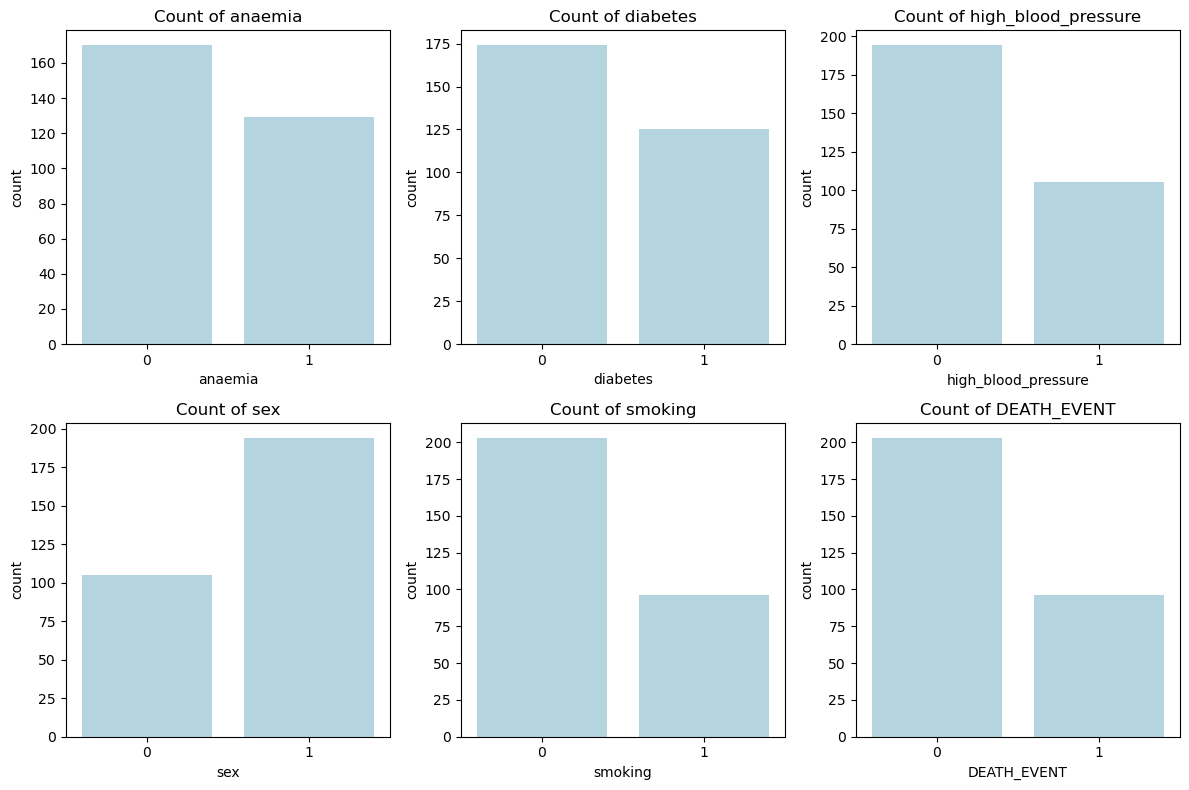

In [5]:

print("DataFrame Info:")
print(df.info())  
print("\n" + "="*50 + "\n")

print("DataFrame Description:")
print(df.describe())  
print("\n" + "="*50 + "\n")

missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)
print("\n" + "="*50 + "\n")

print("Mean DEATH_EVENT by Age:")
print(df.groupby("age")["DEATH_EVENT"].mean())  
print("\n" + "="*50 + "\n")

print("Correlation Matrix:")
correlation_matrix = df.corr(numeric_only=True)
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].hist(figsize=(12,8), bins=20, edgecolor='black')
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 5, i)  
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

categorical_cols = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']
plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=col, data=df, color='lightblue')
    plt.title(f"Count of {col}")
plt.tight_layout()
plt.show()



# Build: Probabilistic modelling

### Hazard model

Our goal is to build a survival model to predict the patient likelihood of death by heart failure. 

Formally, we consider a hazard model describing the risk of death at time $t$. We denote the probability of surviving beyond time $t$ as $$S(t) = P(T \geq t),$$ where $T$ is the random variable representing the survival time, that is the duration until death. The instantaneous risk of death at time $t$ having survived up to time $t$ is given by the hazard rate $$h(t) = \lim_{\Delta t \to 0} \frac{P(t \leq T < t + \Delta t | T \geq t)}{\Delta t} = \frac{f(t)}{S(t)},$$ where $f(t)$ is the probability density function of the survival time $T$. Since $f(t) = -\frac{d}{dt}S(t)$, we can relate the hazard rate to the survival function as $$h(t) = \frac{f(t)}{S(t)} = -\frac{1}{S(t)} \frac{d}{dt}S(t) = -\frac{d}{dt} \log(S(t)).$$ By integrating both sides from 0 to $t$, we obtain the cumulative hazard function $$H(t) = \int_0^t h(u) du = -\int_0^t \frac{d}{du} \log(S(u)) du = -[\log(S(t)) - \log(S(0))] = -\log(S(t))$$ since $S(0) = 1$. Therefore, $S(t) = \exp(-H(t))$. 





### Cox proportional hazard model

In this case study, we will use a Cox proportional hazard model to estimate the risk of death by heart failure for a patient with input features $\mathbf{x}$. The Cox model assumes a parametric hazard rate function $$h(t) = h_0(t) \exp(\boldsymbol{\beta}^T \mathbf{x}),$$ where $h_0(t)$ is the baseline hazard and $\boldsymbol{\beta}$ are model parameters. We consider a simple Cox model with a constant baseline hazard $h_0(t) = \lambda$, for which the cumulative hazard is $H(t) = \lambda t \exp(\boldsymbol{\beta}^T \mathbf{x})$ and the survival function is $S(t) = \exp(-\lambda t \exp(\boldsymbol{\beta}^T \mathbf{x}))$.

For a patient $i$ with features $\mathbf{x}_i$ and observed time of death $t_i$, the likelihood $p(t_i | \mathbf{x}_i, \boldsymbol{\beta})$ of observing this event is given by $$p(T=t_i | \mathbf{x}_i, \boldsymbol{\beta}) = h(t_i | \mathbf{x}_i, \boldsymbol{\beta}) S(t_i | \mathbf{x}_i, \boldsymbol{\beta}) = h(t_i | \mathbf{x}_i, \boldsymbol{\beta})  \exp(-H(t_i | \mathbf{x}_i, \boldsymbol{\beta})).$$ If the patient is still alive, then the time of death is not observed yet, and we only know that $T \geq t_i$. In this case, $t_i$ is the time of censoring (i.e., the time at which the medical follow-up ended) and the likelihood is $$p(T \geq t_i | \mathbf{x}_i, \boldsymbol{\beta}) = S(t_i | \mathbf{x}_i, \boldsymbol{\beta}) = \exp(-H(t_i | \mathbf{x}_i, \boldsymbol{\beta})).$$

Overall, if we indicate with $\delta_i = 1$ the event of death and $\delta_i = 0$ the event of censoring, the likelihood for the $i$-th patient is thus given by $$p(t_i | \mathbf{x}_i, \delta_i, \boldsymbol{\beta}) = h(t_i | \mathbf{x}_i, \boldsymbol{\beta})^{\delta_i} \exp(-H(t_i | \mathbf{x}_i, \boldsymbol{\beta})).$$

<div class="alert alert-success">
    
**Q3**. For the case of uncensored data (i.e., $\delta_i = 1$), draw the probabilistic graphical model associated with the Cox model described above. Assume we have $N$ patients in the dataset, each with features $\mathbf{x}_i$ and time of death $t_i$.
    
</div>

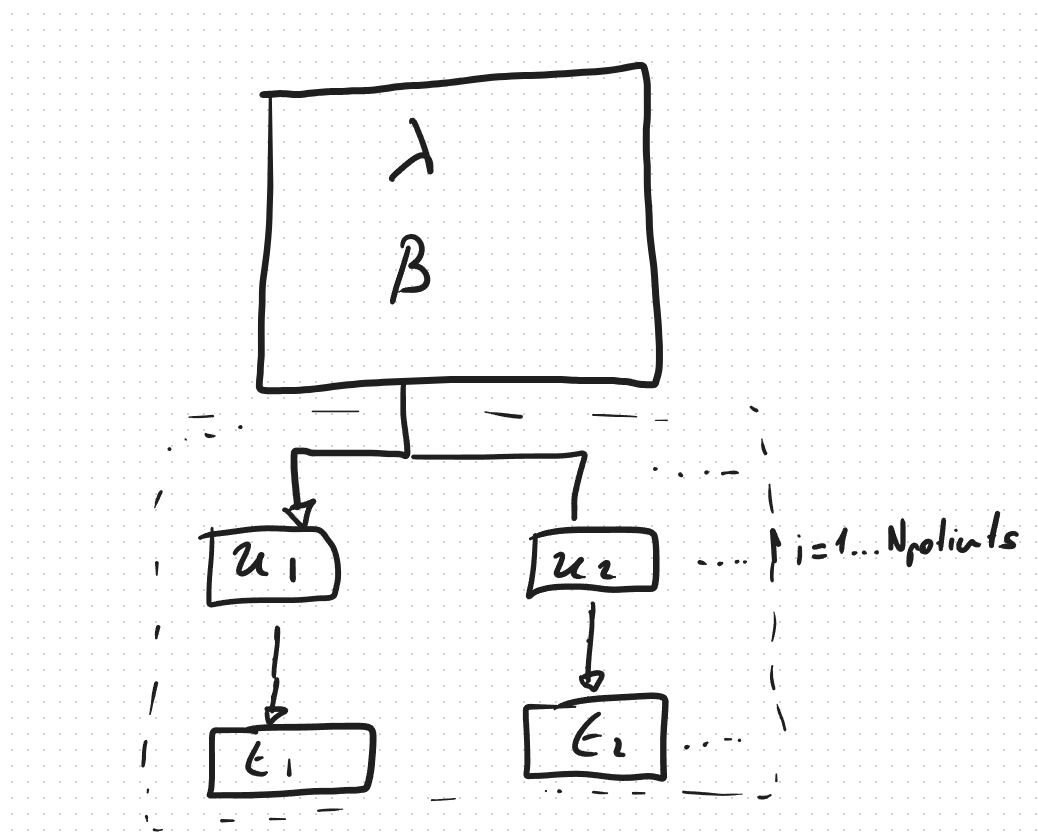

In [6]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
df = pd.read_csv("heart.csv")

x_var = 'high_blood_pressure'  
x = df[x_var].values
t = df['time'].values
delta = df['DEATH_EVENT'].values  


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<div class="alert alert-success">
    
**Q4**. Implement the (conditional) model described above (i.e., the prior, the likelihood, as well as a sampler). For the time being, consider an uninformative prior for the model parameters. 

_Tips_: 
Notice that for our choice of baseline hazard $h_0(t) = \lambda$, the cumulative hazard is $H(t) = \lambda t \exp(\boldsymbol{\beta}^T \mathbf{x}) = \lambda t \, c(\mathbf{x}; \boldsymbol{\beta})$ for $c(\mathbf{x}; \boldsymbol{\beta}) = \exp(\boldsymbol{\beta}^T \mathbf{x})$. Therefore, the probability density function of the survival time is $f(t) = h(t) S(t) = \lambda c(x; \boldsymbol{\beta}) \exp(-\lambda t c(\mathbf{x}; \boldsymbol{\beta}))$, which corresponds to an Exponential distribution with rate $\lambda c(\mathbf{x}; \boldsymbol{\beta})$. 

</div>

In [7]:
x = df['high_blood_pressure'].values

t = df['time'].values

delta = df['DEATH_EVENT'].values

def log_prior(params):
    beta_val, lambda_val = params 
    
    
    lp_beta = norm.logpdf(beta_val, 0, 2)
    
   
    if lambda_val <= 0:
        return -np.inf
    
   
    lp_lambda = gamma.logpdf(lambda_val, a=2, scale=1)
    
   
    return lp_beta + lp_lambda

def log_likelihood(params, t, delta, x):
    beta_val, lambda_val = params  
    
    
    rate = lambda_val * np.exp(beta_val * x)
    
   
    log_lik = delta * np.log(rate) - rate * t
    
    
    return np.sum(log_lik)

def log_posterior(params, t, delta, x):
    
    lp = log_prior(params)
    
    
    if not np.isfinite(lp):
        return -np.inf
    
    
    return lp + log_likelihood(params, t, delta, x)


<div class="alert alert-success">
    
**Q5**. Using a prior predictive check, evaluate and discuss if the prior predictive distribution is realistic. Propose a weakly informative prior that results in more realistic simulated data.

_Tips_: Plot the survival function $S(t)$ for different parameter samples drawn from the prior.
    
</div>

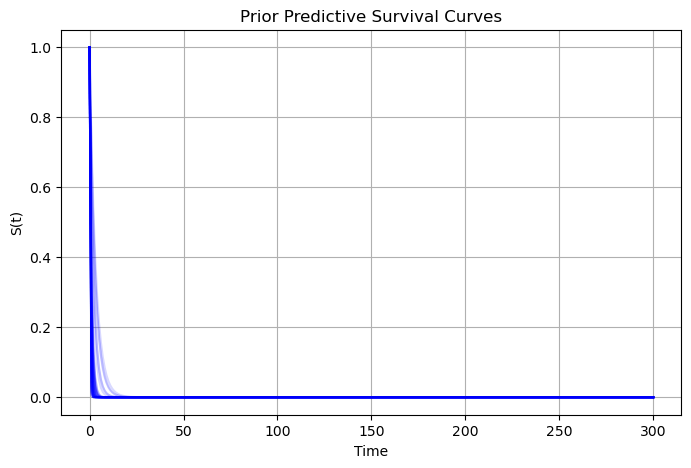

In [8]:
np.random.seed(42)

num_prior_samples = 1000

beta_prior_samps = np.random.normal(0, 2, num_prior_samples)

lambda_prior_samps = gamma.rvs(a=2, scale=1, size=num_prior_samples)

t_grid = np.linspace(0, 300, 300)

plt.figure(figsize=(8, 5))
for i in range(50):  
    rate_i = lambda_prior_samps[i] * np.exp(beta_prior_samps[i] * 0)
    
    S = np.exp(-rate_i * t_grid)
    
    plt.plot(t_grid, S, alpha=0.15, color='blue')

plt.title("Prior Predictive Survival Curves")
plt.xlabel("Time")
plt.ylabel("S(t)")

plt.grid(True)

plt.show()

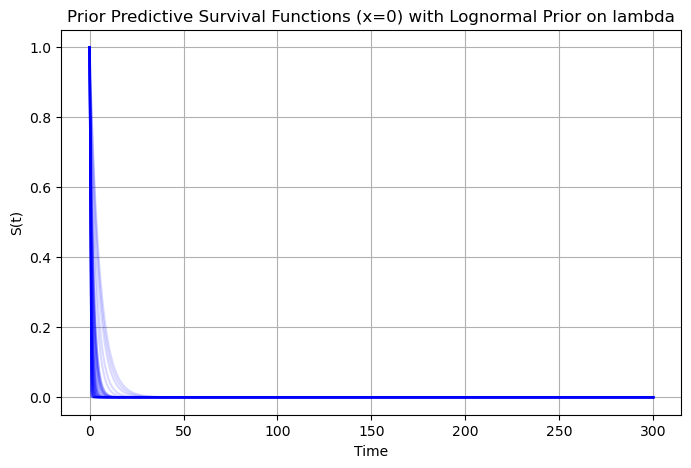

In [9]:
np.random.seed(42)
num_prior_samples = 1000

beta_prior_samps = np.random.normal(0, 2, num_prior_samples)

lambda_prior_samps = np.exp(np.random.normal(0, 1, num_prior_samples))

t_grid = np.linspace(0, 300, 300)
plt.figure(figsize=(8,5))
for i in range(50):
    rate_i = lambda_prior_samps[i] * np.exp(beta_prior_samps[i] * 0)  # x=0
    S = np.exp(-rate_i * t_grid)
    plt.plot(t_grid, S, alpha=0.15, color='blue')
plt.title("Prior Predictive Survival Functions (x=0) with Lognormal Prior on lambda")
plt.xlabel("Time")
plt.ylabel("S(t)")
plt.grid(True)
plt.show()


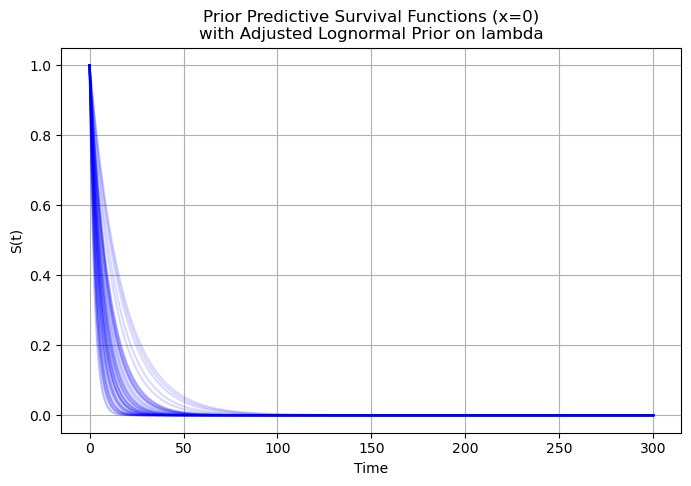

In [10]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
num_prior_samples = 1000

beta_prior_samps = np.random.normal(0, 2, num_prior_samples)

mu_lambda = -2
sigma_lambda = 0.5
lambda_prior_samps = np.exp(np.random.normal(mu_lambda, sigma_lambda, num_prior_samples))

t_grid = np.linspace(0, 300, 300)
plt.figure(figsize=(8,5))
for i in range(50):
    rate_i = lambda_prior_samps[i] * np.exp(beta_prior_samps[i] * 0)  # x=0
    S = np.exp(-rate_i * t_grid)
    plt.plot(t_grid, S, alpha=0.15, color='blue')

plt.title("Prior Predictive Survival Functions (x=0)\nwith Adjusted Lognormal Prior on lambda")
plt.xlabel("Time")
plt.ylabel("S(t)")
plt.grid(True)
plt.show()


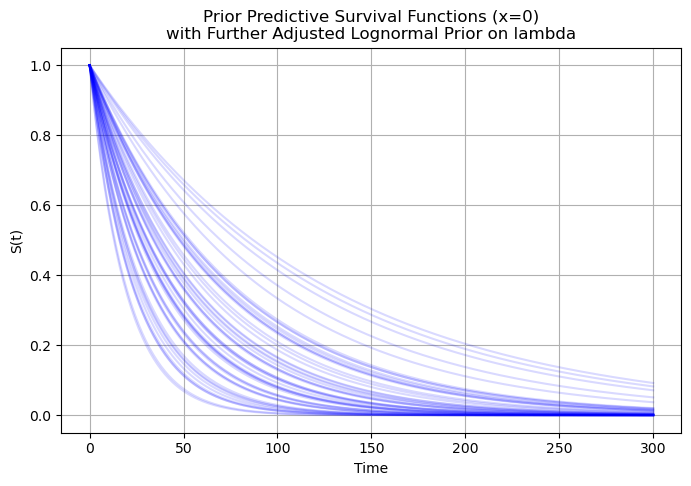

In [11]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
num_prior_samples = 1000

beta_prior_samps = np.random.normal(0, 2, num_prior_samples)

mu_lambda = -4
sigma_lambda = 0.5
lambda_prior_samps = np.exp(np.random.normal(mu_lambda, sigma_lambda, num_prior_samples))

t_grid = np.linspace(0, 300, 300)
plt.figure(figsize=(8,5))
for i in range(50):
    rate_i = lambda_prior_samps[i] * np.exp(beta_prior_samps[i] * 0)  # x=0
    S = np.exp(-rate_i * t_grid)
    plt.plot(t_grid, S, alpha=0.15, color='blue')

plt.title("Prior Predictive Survival Functions (x=0)\nwith Further Adjusted Lognormal Prior on lambda")
plt.xlabel("Time")
plt.ylabel("S(t)")
plt.grid(True)
plt.show()


# Compute: Posterior inference

<div class="alert alert-success">
    
**Q6a**. Using as input features $\mathbf{x}$ the binary variable `high_blood_pressure`, the death or censoring time `time`, and the event indicator `DEATH_EVENT`, compute the posterior distribution of all unobserved random variables.
    
_Tips_: If you use MCMC, initialize the chain(s) around the MAP estimate.
    
</div>

In [12]:
def neg_log_posterior(params, t, delta, x):
    return -log_posterior(params, t, delta, x)

res = minimize(neg_log_posterior, x0=[0,1], args=(t, delta, x), method='L-BFGS-B')
map_est = res.x


ndim = 2
nwalkers = 8  
pos = map_est + 1e-4*np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t, delta, x))
print("Running MCMC (high_blood_pressure)...")
sampler.run_mcmc(pos, 3000, progress=True)
samples_hbp = sampler.get_chain(discard=1000, thin=5, flat=True)

beta_hbp = samples_hbp[:,0]
lambda_hbp = samples_hbp[:,1]


c:\Users\queri\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Running MCMC (high_blood_pressure)...


100%|██████████| 3000/3000 [00:05<00:00, 556.91it/s]


<div class="alert alert-success">
    
**Q7a**. Assess whether your inference results are computationally faithful (check the convergence, mixing, and autocorrelation of the chains).
    
</div>

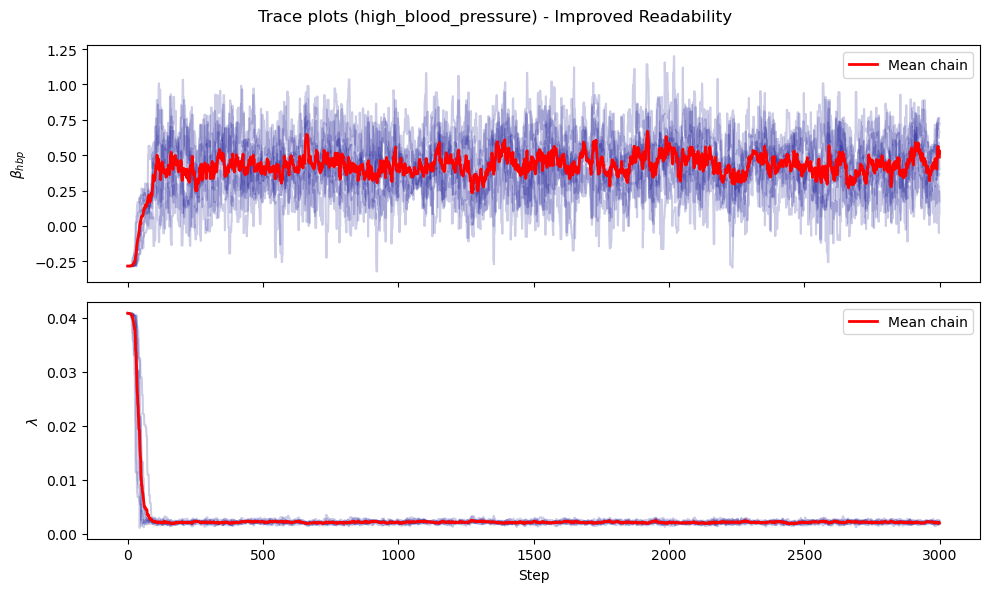

In [13]:
chain = sampler.get_chain() 
fig, axes = plt.subplots(ndim, 1, figsize=(10, 6), sharex=True)
param_names = [r"$\beta_{hbp}$", r"$\lambda$"]
for i in range(ndim):
    for w in range(nwalkers):
        axes[i].plot(chain[:, w, i], color='darkblue', alpha=0.2)
    mean_chain = np.mean(chain[:,:,i], axis=1)
    axes[i].plot(mean_chain, color='red', linewidth=2, label='Mean chain')
    axes[i].set_ylabel(param_names[i])
    axes[i].legend(loc='upper right')
axes[-1].set_xlabel("Step")
plt.suptitle("Trace plots (high_blood_pressure) - Improved Readability")
plt.tight_layout()
plt.show()




<div class="alert alert-success">
    
**Q8a**. Plot the posterior distributions and discuss the results.
    
</div>

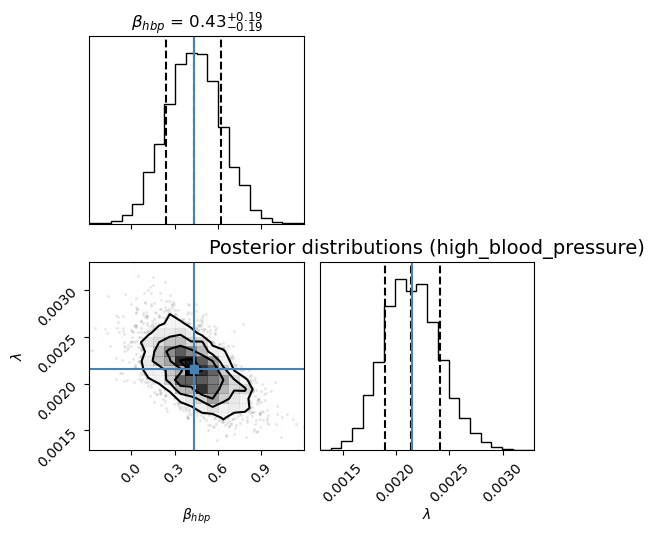

In [14]:
fig = corner.corner(samples_hbp, labels=[r"$\beta_{hbp}$", r"$\lambda$"],
                    truths=[np.mean(beta_hbp), np.mean(lambda_hbp)],
                    quantiles=[0.16,0.5,0.84], show_titles=True, title_fmt=".2f")
plt.title("Posterior distributions (high_blood_pressure)", fontsize=14)
plt.tight_layout()
plt.show()


<div class="alert alert-success">
    
**Q6b, Q7b, Q8b**. Repeat the above steps using instead the binary variable `smoking` as input feature.
    
</div>

c:\Users\queri\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Running MCMC (smoking)...


100%|██████████| 3000/3000 [00:05<00:00, 577.82it/s]


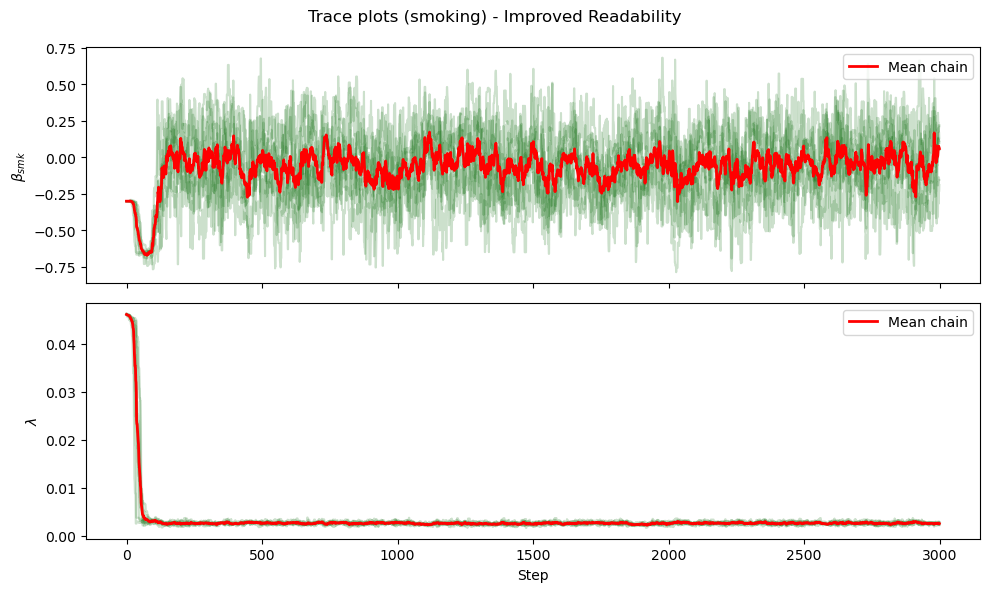

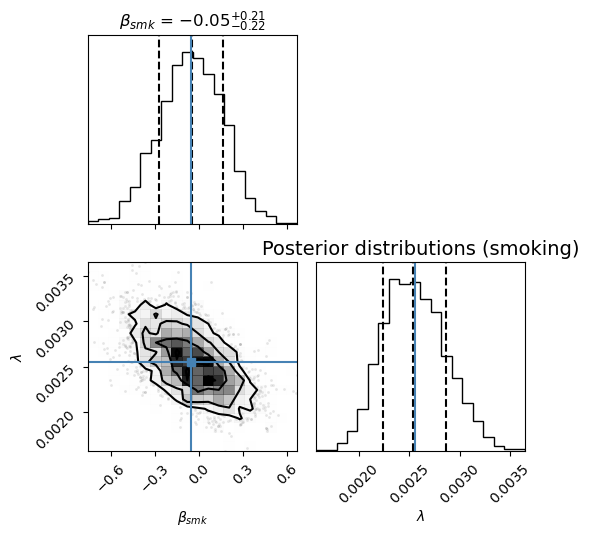

In [15]:
x_smk = df['smoking'].values
res_smk = minimize(neg_log_posterior, x0=[0,1], args=(t, delta, x_smk), method='L-BFGS-B')
map_est_smk = res_smk.x
pos_smk = map_est_smk + 1e-4*np.random.randn(nwalkers, ndim)

sampler_smk = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t, delta, x_smk))
print("Running MCMC (smoking)...")
sampler_smk.run_mcmc(pos_smk, 3000, progress=True)
samples_smk = sampler_smk.get_chain(discard=1000, thin=5, flat=True)

beta_smk = samples_smk[:,0]
lambda_smk = samples_smk[:,1]
chain_smk = sampler_smk.get_chain()
fig, axes = plt.subplots(ndim, 1, figsize=(10, 6), sharex=True)
param_names_smk = [r"$\beta_{smk}$", r"$\lambda$"]
for i in range(ndim):
    for w in range(nwalkers):
        axes[i].plot(chain_smk[:, w, i], color='darkgreen', alpha=0.2)
    mean_chain_smk = np.mean(chain_smk[:,:,i], axis=1)
    axes[i].plot(mean_chain_smk, color='red', linewidth=2, label='Mean chain')
    axes[i].set_ylabel(param_names_smk[i])
    axes[i].legend(loc='upper right')
axes[-1].set_xlabel("Step")
plt.suptitle("Trace plots (smoking) - Improved Readability")
plt.tight_layout()
plt.show()

corner.corner(samples_smk, labels=[r"$\beta_{smk}$", r"$\lambda$"],
              truths=[np.mean(beta_smk), np.mean(lambda_smk)],
              quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt=".2f")
plt.title("Posterior distributions (smoking)", fontsize=14)
plt.tight_layout()
plt.show()

# Criticize

<div class="alert alert-success">
    
**Q9**. Evaluate the posterior predictive distribution for the two models and discuss the results.

_Tips_: Plot the survival function $S(t)$ for different parameter samples drawn from the posterior against the empirical survival function of the observed data $\hat{S}(t) = \frac{N(t)}{N}$, where $N(t)$ is the number of patients who survived beyond time $t$.
    
</div>

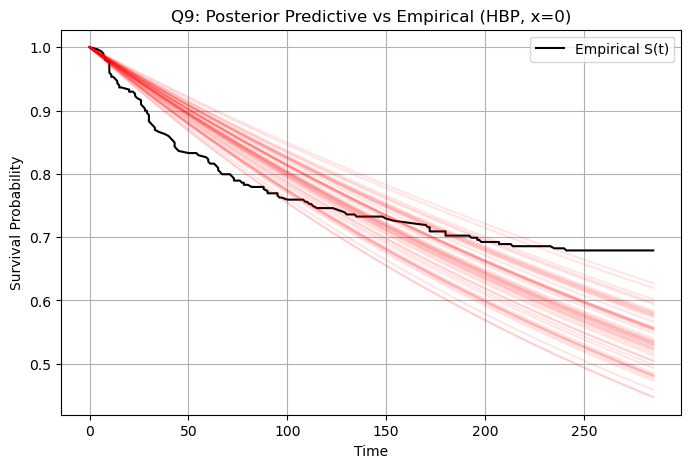

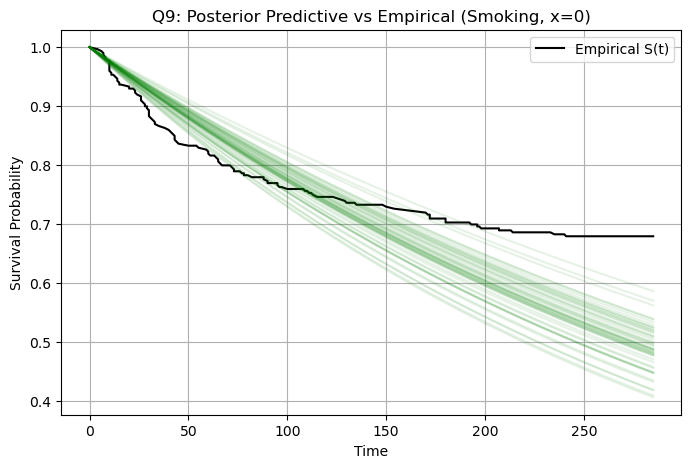

In [16]:
def empirical_survival(t, delta):
    order = np.argsort(t)
    t_sorted = t[order]
    delta_sorted = delta[order]
    N = len(t)
    alive = N
    points = [(0, alive)]
    for i in range(N):
        if delta_sorted[i] == 1:
            alive -= 1
        points.append((t_sorted[i], alive))
    surv_fraction = [(ti, nc/N) for (ti, nc) in points]
    return np.array(surv_fraction)

emp_surv = empirical_survival(t, delta)
time_grid = np.linspace(0, np.max(t), 300)

plt.figure(figsize=(8,5))
plt.plot(emp_surv[:,0], emp_surv[:,1], 'k-', label='Empirical S(t)')
for i in np.random.choice(len(samples_hbp), 50, replace=False):
    rate_i = samples_hbp[i,1]*np.exp(samples_hbp[i,0]*0) 
    S_post = np.exp(-rate_i*time_grid)
    plt.plot(time_grid, S_post, alpha=0.1, color='red')
plt.title("Q9: Posterior Predictive vs Empirical (HBP, x=0)")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(emp_surv[:,0], emp_surv[:,1], 'k-', label='Empirical S(t)')
for i in np.random.choice(len(samples_smk), 50, replace=False):
    rate_i = samples_smk[i,1]*np.exp(samples_smk[i,0]*0)
    S_post_smk = np.exp(-rate_i*time_grid)
    plt.plot(time_grid, S_post_smk, alpha=0.1, color='green')
plt.title("Q9: Posterior Predictive vs Empirical (Smoking, x=0)")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()
plt.show()


<div class="alert alert-success">
    
**Q10**. Evaluate the posterior predictive distributions of test quantities of replicated data and discuss the results.
    
</div>

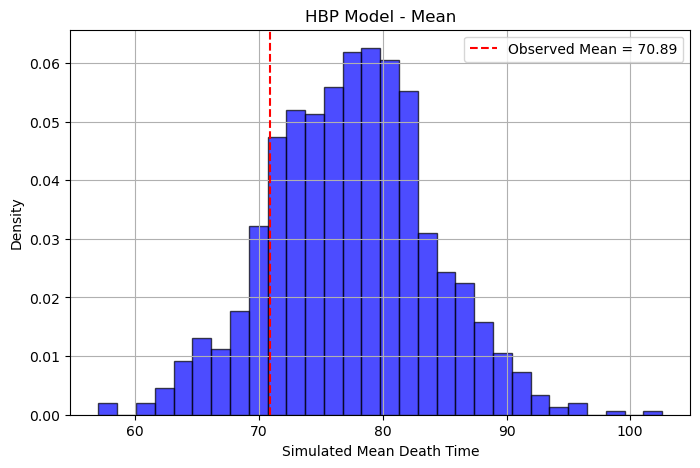

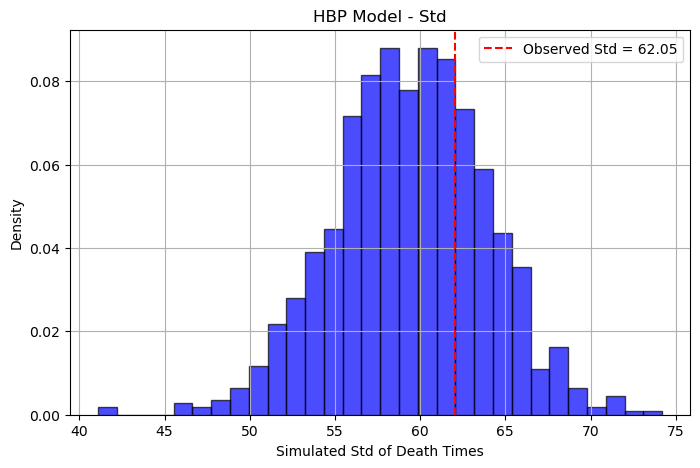

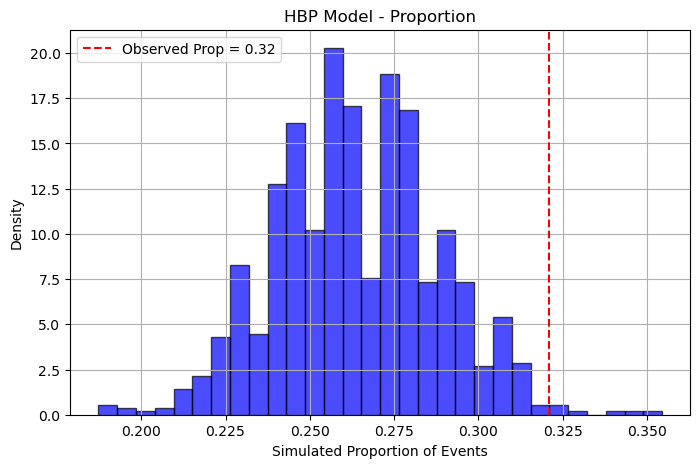

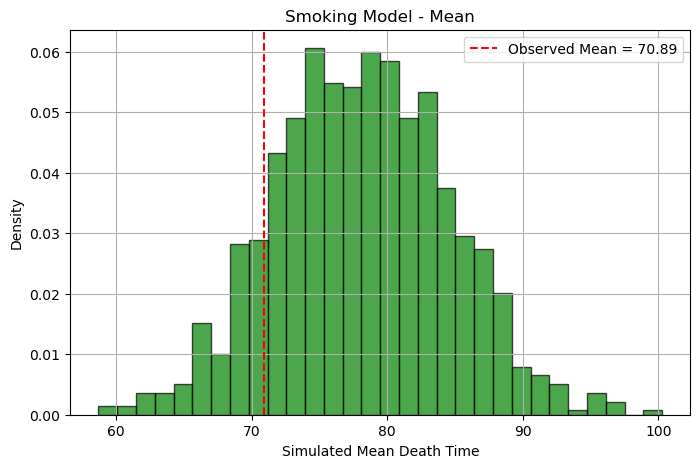

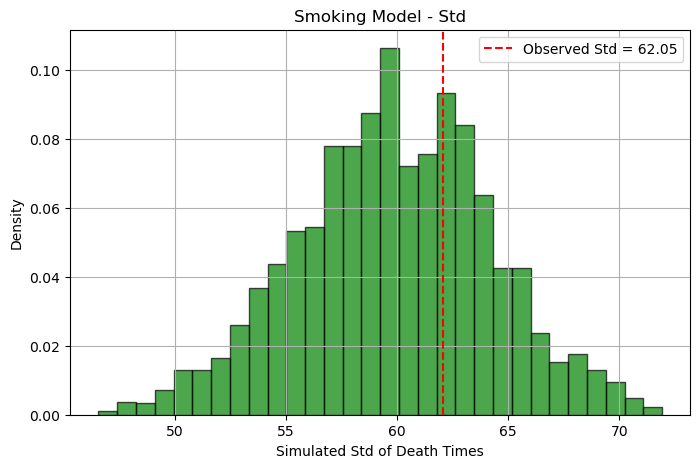

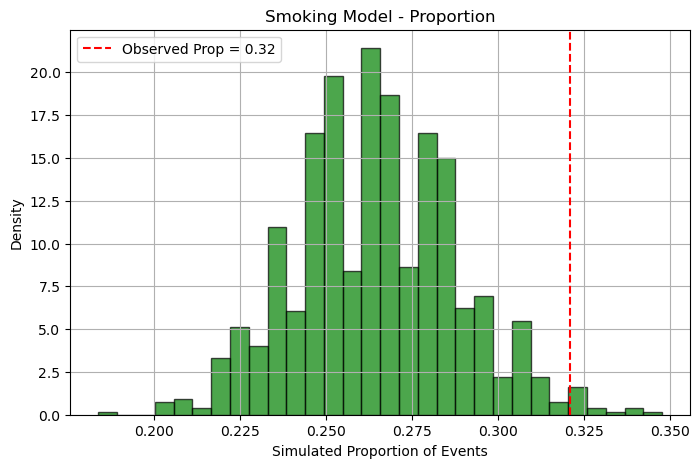

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_event_time_from_posterior(post_samples, covariate):
    idx = np.random.randint(0, post_samples.shape[0])
    beta, lam = post_samples[idx]
    hazard = lam * np.exp(beta * covariate)
    return np.random.exponential(scale=1.0 / hazard)

def replicate_dataset(samples, covariates, observed_times):
    simulated_times, simulated_events = [], []
    for cov, follow_up in zip(covariates, observed_times):
        sim_time = simulate_event_time_from_posterior(samples, cov)
        if sim_time <= follow_up:
            simulated_times.append(sim_time)
            simulated_events.append(1)
        else:
            simulated_times.append(follow_up)
            simulated_events.append(0)
    return simulated_times, simulated_events

def plot_test_statistic_distribution(pp_dist, obs_val, title_str):
    plt.figure(figsize=(8, 5))
    plt.hist(pp_dist, bins=30, density=True, alpha=0.7, color='lightblue', edgecolor='black')
    plt.axvline(obs_val, color='red', linestyle='--', label=f'Observed = {obs_val:.2f}')
    plt.title(title_str)
    plt.xlabel("Replicated Test Statistic")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

def posterior_predictive_analysis(samples, covariates, observed_times, observed_mean, title, color):
    simulated_means = []
    for _ in range(1000):
        sim_times, sim_events = replicate_dataset(samples, covariates, observed_times)
        death_times = [t for t, e in zip(sim_times, sim_events) if e == 1]
        simulated_means.append(np.mean(death_times) if death_times else 0.0)
    plt.figure(figsize=(8, 5))
    plt.hist(simulated_means, bins=30, density=True, alpha=0.7, color=color, edgecolor='black')
    plt.axvline(observed_mean, color='red', linestyle='--', label=f'Observed Mean = {observed_mean:.2f}')
    plt.title(title)
    plt.xlabel("Simulated Mean Death Time")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

def posterior_predictive_analysis_std(samples, covariates, observed_times, observed_std, title, color):
    simulated_stds = []
    for _ in range(1000):
        sim_times, sim_events = replicate_dataset(samples, covariates, observed_times)
        death_times = [t for t, e in zip(sim_times, sim_events) if e == 1]
        simulated_stds.append(np.std(death_times) if len(death_times) > 1 else 0.0)
    plt.figure(figsize=(8, 5))
    plt.hist(simulated_stds, bins=30, density=True, alpha=0.7, color=color, edgecolor='black')
    plt.axvline(observed_std, color='red', linestyle='--', label=f'Observed Std = {observed_std:.2f}')
    plt.title(title)
    plt.xlabel("Simulated Std of Death Times")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

def posterior_predictive_analysis_prop(samples, covariates, observed_times, observed_prop, title, color):
    simulated_props = []
    for _ in range(1000):
        sim_times, sim_events = replicate_dataset(samples, covariates, observed_times)
        simulated_props.append(np.mean(sim_events))
    plt.figure(figsize=(8, 5))
    plt.hist(simulated_props, bins=30, density=True, alpha=0.7, color=color, edgecolor='black')
    plt.axvline(observed_prop, color='red', linestyle='--', label=f'Observed Prop = {observed_prop:.2f}')
    plt.title(title)
    plt.xlabel("Simulated Proportion of Events")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

observed_mean_death = np.mean(t[delta == 1])
observed_std_death = np.std(t[delta == 1])
observed_prop_death = np.mean(delta)


posterior_predictive_analysis(samples_hbp, df['high_blood_pressure'].values, t, observed_mean_death, "HBP Model - Mean", "blue")
posterior_predictive_analysis_std(samples_hbp, df['high_blood_pressure'].values, t, observed_std_death, "HBP Model - Std", "blue")
posterior_predictive_analysis_prop(samples_hbp, df['high_blood_pressure'].values, t, observed_prop_death, "HBP Model - Proportion", "blue")

posterior_predictive_analysis(samples_smk, df['smoking'].values, t, observed_mean_death, "Smoking Model - Mean", "green")
posterior_predictive_analysis_std(samples_smk, df['smoking'].values, t, observed_std_death, "Smoking Model - Std", "green")
posterior_predictive_analysis_prop(samples_smk, df['smoking'].values, t, observed_prop_death, "Smoking Model - Proportion", "green")


<div class="alert alert-success">
    
**Q11**. Evaluate the posterior predictive performance of both models and discuss the results.

</div>

In [19]:
def posterior_predictive_dataset(samples, x_data):
    return [simulate_event_time_from_posterior(samples, xv) for xv in x_data]

num_reps = 300
simulations_hbp = np.array([posterior_predictive_dataset(samples_hbp, df['high_blood_pressure']) for _ in range(num_reps)])
simulations_smk = np.array([posterior_predictive_dataset(samples_smk, df['smoking']) for _ in range(num_reps)])

low_hbp = np.percentile(simulations_hbp, 2.5, axis=0)
high_hbp = np.percentile(simulations_hbp, 97.5, axis=0)
coverage_hbp = np.mean((t >= low_hbp) & (t <= high_hbp))*100

low_smk = np.percentile(simulations_smk, 2.5, axis=0)
high_smk = np.percentile(simulations_smk, 97.5, axis=0)
coverage_smk = np.mean((t >= low_smk) & (t <= high_smk))*100

print("Q11: Predictive Interval Coverage")
print("HBP model coverage: {:.2f}%".format(coverage_hbp))
print("Smoking model coverage: {:.2f}%".format(coverage_smk))


Q11: Predictive Interval Coverage
HBP model coverage: 95.32%
Smoking model coverage: 95.32%


# Revise

<div class="alert alert-success">
    
**Q12**. Explain and motivate what could be tried to further improve the probabilistic model considered in this study. (No implementation is required.)

</div>

## Suggestions to Improve the Model Fit

1. **Use a Non-Constant Hazard Function**  
   The current model assumes a constant hazard rate, which may not be realistic in many cases. Using a hazard function that varies over time could provide a more accurate representation of the underlying process and improve the model fit.

2. **Incorporate Additional Covariates**  
   The model currently uses only `high_blood_pressure` and `smoking` as predictors. Adding other relevant variables could enhance the model's explanatory power and provide a deeper understanding of the data.
